In [ ]:
%load_ext autoreload
%autoreload 2
%load_ext Cython

from __future__ import division
from __future__ import print_function

import sys,time,datetime,copy,subprocess,itertools,pickle,warnings,json,gc,numbers

import numpy as np
import scipy as sp
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib as mpl

from IPython.core.display import display, HTML
display(HTML("""
<style>
.rendered_html pre { background-color:#eff0f1; margin:10px 0px 0px 0px; padding:14px }
.rendered_html pre code { background-color:#eff0f1;}
</style>
"""))


# Hawkes

A python package for simulation and inference of Hawkes processes.

### Contents
1. Introdution  
2. Hawkes process  
3. Simulation  
4. Inference  

# 1. Introduction

### repository

https://github.com/omitakahiro/Hawkes/

### requirement
- numpy
- scipy
- pandas
- matplotlib
- cython

### setup

1. Download Hawkes-master.zip from https://github.com/omitakahiro/Hawkes/archive/master.zip and unzip it.
2. Place a "Hawkes" folder (in a "Hawkes-master" folder) into the current directory.

# 2. Hawkes process

A Hawkes process is a simple point process model of the clustering behaviour of event occurrences. In the Hawkes process, the occurrence rate of a event at time $t$ given a history $H_t=\{t_i<t\}$ is given as
$$\lambda(t|H_t)=\mu(t) + \sum_{t_i<t} f(t-t_i)$$
, where $\{t_i\}$ represent the occurrence times of events.
$\mu(t)$ and $f(\tau)$ represent a baseline function and a kernel function, respectively.

# 3. Simulation

## 3.1. preparation

- import a "Hawkes" package

```python
import Hawkes as hk
```

## 3.2. setup the model


### 3.2.1. create a ```simulator```

```python
model = hk.simulator()
```

### 3.2.2. set the kernel function $f(\tau)$

Choose a type of the kernel function using the ```.set_kernel()``` method. There are three options.

- exponential function : $f(\tau)=\alpha \beta \exp(-\beta \tau)$

```python
model.set_kernel('exp')
```  

- multiple exponential function : $f(\tau)=\sum_{i=1}^{num\_exp}\alpha_i \beta_i \exp(-\beta_i \tau)$

```python
model.set_kernel('exp',num_exp=2) # sum of two exponential functions
```

- power-low function : $f(\tau)=k/(\tau+c)^p$

```python
model.set_kernel('pow')
```

### 3.2.3. set a baseline function $\mu(t)$

Choose a type of the baseline function using the ```.set_badeline()``` method. There are two options.

- constant baseline: $\mu(t)=\mu$

```python
model.set_baseline('const')
```  

- custom basesline function: 

```python
mu_t = lambda x: 0.2 + 0.1*np.sin(2*np.pi*x/100) # baseline function
model.set_baseline('custom',l_baseline=mu_t)
```  

```mu_t``` must return a float if the input is a float, and return a numpy.ndarray if the input is a numpy.ndarray.

### 3.2.4. set the parameter values

Set the parameter values using the ```.set_parameter()``` method. The parameter values are passed to the method as a dictionary. 

- an example for the hawkes process with the exponential kernel function and the constant baseline.

```python
para = {'mu':0.1, 'alpha':0.5, 'beta':10.0}
model.set_parameter(para)
```

- an example for the hawkes process with the sum-of-two-exponential-functions kernel and the constant baseline.

```python
para = {'mu':0.1, 'alpha':[0.2,0.4], 'beta':[1.0,10.0]}
model.set_parameter(para)
```

- an example for the hawkes process with the power-law kernel function and the time-varying baseline.

```python
para = {'k':0.8, 'p':1.5, 'c':5.0}
model.set_parameter(para)
```

## 3.3. simulate a event sequence

Generate a event sequence by using the ```.simulate()``` method. This method receives ```itv```, a list that contains the start and end of the observation interval, and returns ```T```, a numpy.ndarray that contains the times of the simulated events.

```python
itv = [0,100] # the observation interval
T = model.simulate(itv)
```

## 3.4. plot

- plot the time verseus the cumulative number of the simulated events

```python
model.plot_N() 
```

- plot the time versus the conditional intensity function $\lambda(t|H_t)$

```python
model.plot_l() 
```

## 3.4. code examples

### 3.4.1. simulation of a Hawkes process with an exponential kernel and a constant baseline


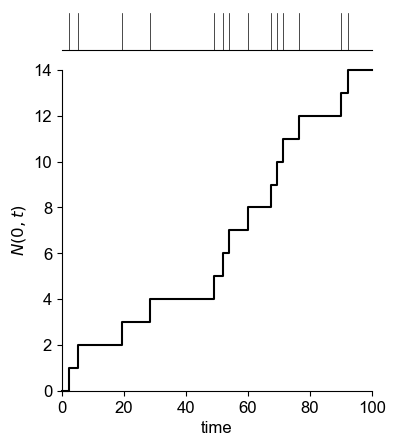

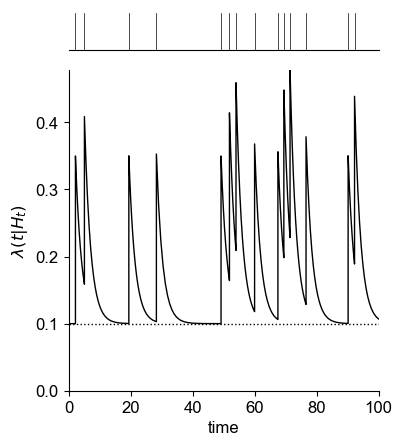

In [22]:
import Hawkes as hk

para = {'mu':0.1, 'alpha':0.5, 'beta':0.5}
itv = [0,100]
model = hk.simulator().set_kernel('exp').set_baseline('const').set_parameter(para)
T = model.simulate(itv)
model.plot_N()
model.plot_l()

(the dashed line represents a baseline intensity)

### 3.4.2. simulation of a Hawkes process with a power-law kernel and a time-varying baseline

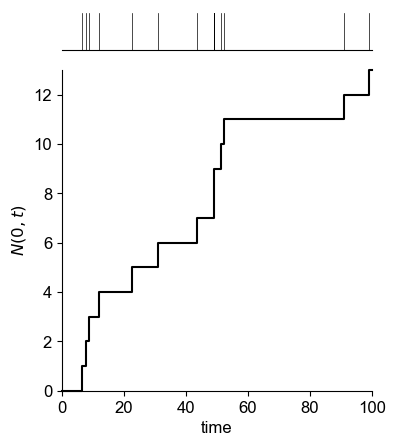

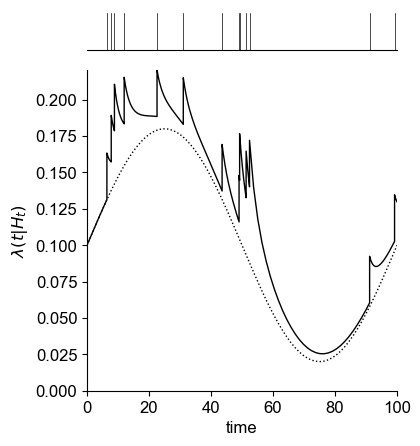

In [24]:
import Hawkes as hk

para = {'k':0.8, 'p':2.0, 'c':5.0}
mu_t = lambda x: ( 1.0 + 0.8*np.sin(2*np.pi*x/100) ) * 0.1
itv = [0,100]

model = hk.simulator().set_kernel('pow').set_baseline('custom',l_custom=mu_t).set_parameter(para)
T = model.simulate(itv)

model.plot_N()
model.plot_l()

# 4. Inference

This package provides a routine for the maximum likelihood estimation of the Hawkes processes.

## 4.1 preparation 

- import a "Hawkes" package 

```python
import Hawkes as hk
```

## 4.2. build the model


### 4.2.1. create a ```estimator```

```python
model = hk.estimator()
```

### 4.2.2. choose the kernel function $f(\tau)$

Choose a type of the kernel function using the ```.set_kernel()``` method. There are three options.

- exponential function : $f(\tau)=\alpha \beta \exp(-\beta \tau)$

```python
model.set_kernel('exp')
```  

- multiple exponential function : $f(\tau)=\sum_{i=1}^{num\_exp}\alpha_i \beta_i \exp(-\beta_i \tau)$

```python
model.set_kernel('exp',num_exp=2) # sum of two exponential functions
```

- power-low function : $f(\tau)=k/(\tau+c)^p$

```python
model.set_kernel('pow')
```

### 4.2.3. set a baseline function $\mu(t)$

Choose a type  of a baseline function using the ```.set_baseline()``` method. There are three options.

- constant baseline: $\mu(t)=\mu$

```python
model.set_baseline('const')
```  

- piecewise linear baseline: 

![alt text](plinear.png)

```num_basis``` represents the number of the knots (the vertical dotted lines), The parameters to be estimated $\{\mu_1,\mu_2,\cdots,\mu_{num\_basis}\}$ are the values at the knots (the open circles).

```python
model.set_baseline('plinear',num_basis=6)
```  

- log-linear baseline:  

In a log-linear model, the baseline function $\mu(t)$ is given by
$$\mu(t) = \exp\left[ \sum_{i=1}^{num\_basis} \mu_i f_i(t) \right]$$
, where $\{f_i(t)\}$ represent the basis functions and $\{\mu_i\} are the parameters to be estimated$. 
Let us consider the observation interval $[0, l]$ and the cosine bump function $\hat{f}(x)$ defined by $\hat{f}(x)=[cos(\frac{\pi x}{2})+1]/4 \ \ (|x|\le 2),\ 0\ (otherwise)$.
Here we employ the basis functions given as  $f_i(x)= \hat{f}\left(\frac{x-(i-2)w}{w}\right) (i=1,2,\cdots,num\_basis)$, where we have $w=l/(num\_basis-3)$. ```num_basis ``` represents the number of the basis functions.

![alt text](cosbump.png)

```python
model.set_baseline('loglinear',num_basis=num_basis)
```  

## 4.3. estimate the parameters from the data

Estimate the model parameters using the ```.fit()``` method. This method receives ```T```, a numpy.ndarray that contains the times of the simulated events, and ```itv``` a list that contains the start and end of the observation interval.
 
```python
itv = [0,100] # the observation interval
model.fit(T,itv) # T is the event times (numpy.ndarray)
print("parameter:",model.parameter) # the estimated parameter values
print("branching ratio:",model.br) # the branching ratio
print("log-likelihood:",model.L) # the log-likelihood of the estimated parameter values
print("AIC:",model.AIC) # the AIC of the estimated parameter values
```

## 4.4. plot

- plot the time verseus the cumulative number of the simulated events

```python
model.plot_N() 
```

- plot the time versus the conditional intensity function $\lambda(t|H_t)$

```python
model.plot_l() 
```

## 4.5. diagnostic analysis

If the estimated model is correct, the transformed event occurrence times, given as $\{t'_i = \int_0^{t_i}\lambda(t|H_t)dt\}$, are uniformly distributed in the interval $[0,\int_0^{l}\lambda(t|H_t)dt]$ ($l$ is the length of the observation interval). This property enables us to validate the estimated model.

```python
# T_trans: a list of transformed event occurrence times, itv_trans: the transformed observation interval
[T_trans, itv_trans] = model.t_trans() 
# Kormogorov-Smirnov test under the null hypothesis that the transformed event occurrence times are uniformly distributed
model.plot_KS() 
```

## 4.6. forecasting

Simulate the future event occurrences by using the ```.predict()``` method. 

```python
en_f = 200 # the end of the time interval for the simulation
model.predict(en_f,num_seq=100) # num_seq represents the number of simulated sequences.
model.plot_N_pred() # plot the predicted sequence
```

## 4.4. code examples

### 4.4.1. estimation and forecasting of a Hawkes process with an sum-of-two-exponential-functions kernel and a constant baseline

We first generate a simulated sequence from a Hawkes process with given parameter values.

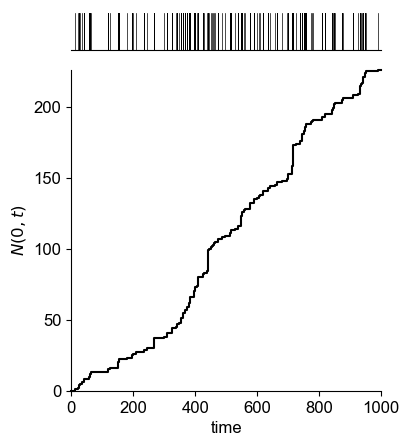

In [25]:
import Hawkes as hk

para = {"mu":0.1, "alpha":[0.25,0.35], "beta":[1.0,10.0]}
itv = [0,1000]
model_simulation = hk.simulator().set_kernel('exp',num_exp=2).set_baseline('const').set_parameter(para)
T_simulation = model_simulation.simulate(itv)
model_simulation.plot_N()

- Infrence 

In [26]:
model = hk.estimator().set_kernel('exp',num_exp=2).set_baseline('const')
model.fit(T_simulation,itv) 
print("parameter:",model.parameter) # the estimated parameter values
print("branching ratio:",model.br) # the branching ratio
print("log-likelihood:",model.L) # the log-likelihood of the estimated parameter values
print("AIC:",model.AIC) # the AIC of the estimated parameter values

parameter: {'mu': 0.11027704770683464, 'alpha': array([0.11833559, 0.39371288]), 'beta': array([1.26618688, 7.74000561])}
branching ratio: 0.5120484729064047
log-likelihood: -372.61259012698997
AIC: 755.2251802539799


- diagnostic analysis

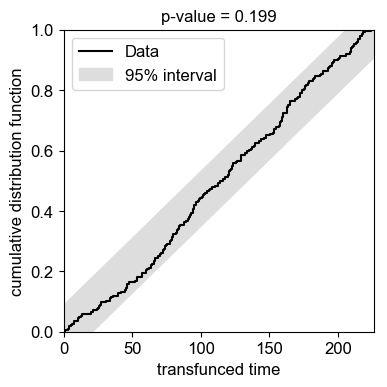

In [27]:
model.plot_KS()

- forecasting

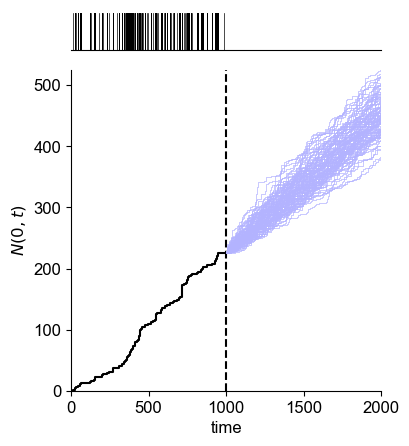

In [28]:
T_pred = model.predict(2000,100) # generate 100 event sequences in [1000,2000] 
model.plot_N_pred() # thin blue lines represent the simulated sequences

### 4.4.2. estimation of a Hawkes process with an exponential kernel and a time-varying baseline

- We first generate a simulated sequence from a Hawkes process with given parameter values.

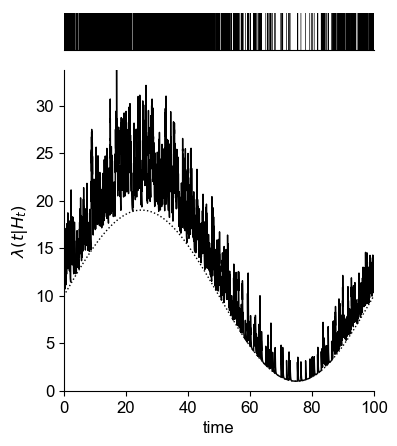

In [29]:
import Hawkes as hk

para = {"alpha":0.2,"beta":10.0}
mu_t = lambda x: 10.0 + 9.0*np.sin(2*np.pi*x/100)
itv = [0,100]
model_simulation = hk.simulator().set_kernel('exp').set_baseline('custom',l_custom=mu_t).set_parameter(para)
T_simulation = model_simulation.simulate(itv)
model_simulation.plot_l()

- Inference using the piecewise linear model and log-linear model

In [30]:
## inference using the picewise linear baseline model
model_plinear =hk.estimator().set_kernel('exp').set_baseline("plinear",num_basis=6)
model_plinear.fit(T_simulation,itv) 
print("piecewise linear model")
print("parameter:",model_plinear.parameter) # the estimated parameter values
print("branching ratio:",model_plinear.br) # the branching ratio
print("log-likelihood:",model_plinear.L) # the log-likelihood of the estimated parameter values
print("AIC:",model_plinear.AIC) # the AIC of the estimated parameter values
print()

## inference using the picewise linear baseline model
model_loglinear = hk.estimator().set_kernel('exp').set_baseline("loglinear",num_basis=6)
model_loglinear.fit(T_simulation,itv) 
print("log linear model")
print("parameter:",model_loglinear.parameter) # the estimated parameter values
print("branching ratio:",model_loglinear.br) # the branching ratio
print("log-likelihood:",model_loglinear.L) # the log-likelihood of the estimated parameter values
print("AIC:",model_loglinear.AIC) # the AIC of the estimated parameter values

piecewise linear model
parameter: {'mu': array([11.05380965, 21.09627527, 15.88458415,  3.17815557,  0.91596311,
       10.40489442]), 'alpha': 0.15364352894348424, 'beta': 19.679334824429983}
branching ratio: 0.15364352894348424
log-likelihood: 2139.810091514924
AIC: -4263.620183029848

log linear model
parameter: {'mu': array([ 2.74508492,  0.16703889,  6.41789878, -1.49969089,  0.46913586,
       10.96477156]), 'alpha': 0.18633883113778255, 'beta': 15.6246829812573}
branching ratio: 0.18633883113778255
log-likelihood: 2132.3514001224285
AIC: -4248.702800244857


- compare the true baseline and the estimated ones

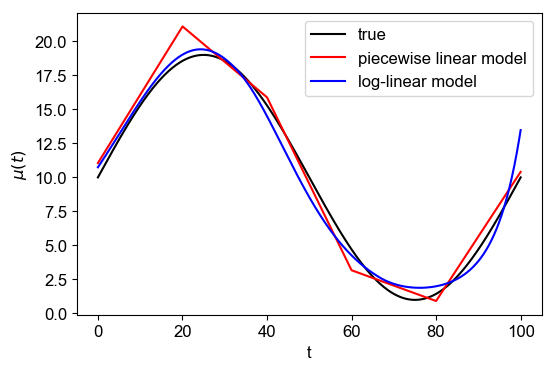

In [31]:
x = np.linspace(0,100,1000)

plt.figure(dpi=100)
plt.plot(x,model_simulation.baseline.l(x),"k-",label="true") # true baseline 
plt.plot(x,model_plinear.baseline.l(x),"r-",label="piecewise linear model") # piecewiese linear model
plt.plot(x,model_loglinear.baseline.l(x),"b-",label="log-linear model") # log-linear model
plt.xlabel("t")
plt.ylabel(r"$\mu(t)$")
plt.legend()
pass